# Nexus Trainer - Handwritten Digit Recognition (MNIST)

This notebook details the process of training a Convolutional Neural Network (CNN) to recognize handwritten digits from the MNIST dataset. It covers data loading, preprocessing, model building, training with callbacks, evaluation, and saving the trained model along with some visualization.

## 1. Imports and Setup

This section imports all necessary libraries and modules for the project, including TensorFlow/Keras for model building, NumPy for numerical operations, Matplotlib for plotting, and OS/Time for utilities.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import os
import time

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.19.0
Keras version: 3.9.2


## 1. Dataset Loading & Preprocessing

This section covers:
- Loading the MNIST dataset.
- Exploring the data by visualizing sample images.
- Preprocessing the image data (reshaping, normalization) and labels (one-hot encoding) to prepare them for the CNN.

In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Number of training samples: {x_train.shape[0]}")
print(f"Number of test samples: {x_test.shape[0]}")
print(f"Image dimensions: {x_train.shape[1]}x{x_train.shape[2]} pixels")

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
Number of training samples: 60000
Number of test samples: 10000
Image dimensions: 28x28 pixels


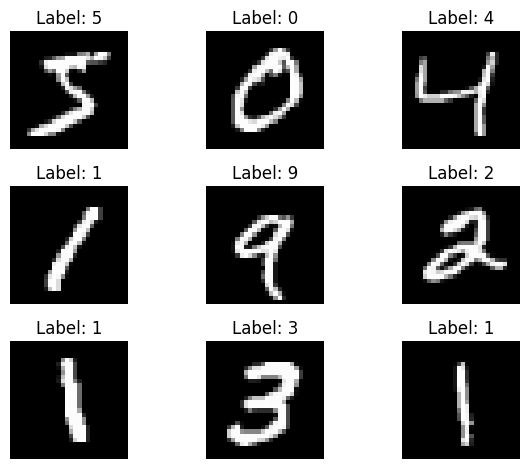

A few training labels: [5 0 4 1 9 2 1 3 1]


In [3]:
# Display some images from the dataset
num_images_to_show = 9
for i in range(num_images_to_show):
    plt.subplot(3, 3, i + 1) # Create a 3x3 grid of subplots
    plt.imshow(x_train[i], cmap='gray') # Display image in grayscale
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off') # Turn off axis numbers and ticks
plt.tight_layout() # Adjust subplot params for a tight layout
plt.show()

print(f"A few training labels: {y_train[:num_images_to_show]}")

In [4]:
# Image dimensions
img_rows, img_cols = 28, 28

# CNNs expect a channel dimension (1 for grayscale, 3 for RGB)
# Keras checks the image_data_format: 'channels_first' (1, 28, 28) or 'channels_last' (28, 28, 1)
if K.image_data_format() == 'channels_first':
    x_train_reshaped = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test_reshaped = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # 'channels_last' is more common with TensorFlow backend
    x_train_reshaped = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Normalize pixel values from 0-255 to 0-1 (float)
# This helps the network learn better and faster
x_train_normalized = x_train_reshaped.astype('float32') / 255.0
x_test_normalized = x_test_reshaped.astype('float32') / 255.0

print(f"x_train_normalized shape: {x_train_normalized.shape}")
print(f"x_test_normalized shape: {x_test_normalized.shape}")
print(f"Sample pixel values after normalization: {x_train_normalized[0, 10:12, 10:12, 0]}") # Show a small patch

# Convert class vectors to binary class matrices (one-hot encoding)
# e.g., label '5' becomes [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
num_classes = 10 # Digits 0-9
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

print(f"\nOriginal y_train[0]: {y_train[0]}")
print(f"One-hot encoded y_train_categorical[0]: {y_train_categorical[0]}")

x_train_normalized shape: (60000, 28, 28, 1)
x_test_normalized shape: (10000, 28, 28, 1)
Sample pixel values after normalization: [[0.00392157 0.6039216 ]
 [0.         0.54509807]]

Original y_train[0]: 5
One-hot encoded y_train_categorical[0]: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 2. Model Architecture

Here, we define the Convolutional Neural Network (CNN) architecture.
The model consists of convolutional layers for feature extraction, max-pooling layers for downsampling, dropout layers for regularization, and dense layers for classification.

In [5]:
# model building
model = Sequential()

# Layer 1: Convolutional Layer
# 32 filters, each 3x3 in size. 'relu' activation is common.
# input_shape is only needed for the first layer.
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

# Layer 2: Another Convolutional Layer
# 64 filters, 3x3.
model.add(Conv2D(64, (3, 3), activation='relu'))

# Layer 3: Max Pooling Layer
# Reduces the spatial dimensions (height and width) by taking the max value
# in a 2x2 window. This helps make the network more robust to variations.
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Dropout Layer
# Randomly sets a fraction (25% here) of input units to 0 at each update
# during training. Helps prevent overfitting.
model.add(Dropout(0.25))

# Layer 5: Flatten Layer
# Converts the 2D feature maps from the pooling layer into a 1D vector
# so it can be fed into a Dense (fully connected) layer.
model.add(Flatten())

# Layer 6: Dense (Fully Connected) Layer
# A standard neural network layer. 128 neurons, 'relu' activation.
model.add(Dense(128, activation='relu'))

# Layer 7: Another Dropout Layer
model.add(Dropout(0.5)) # Higher dropout before the final layer can be beneficial

# Layer 8: Output Layer (Dense)
# num_classes (10) neurons, one for each digit.
# 'softmax' activation outputs a probability distribution over the classes.
# The class with the highest probability is the model's prediction.
model.add(Dense(num_classes, activation='softmax'))

# Print a summary of the model architecture
model.summary()

C:\Users\Acer\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Model Compilation & Training Setup

This section involves:
- Compiling the defined CNN model, specifying the optimizer, loss function, and evaluation metrics.
- Setting up callbacks (`EarlyStopping`, `ModelCheckpoint`, `ReduceLROnPlateau`) to enhance the training process by preventing overfitting, saving the best model, and adjusting the learning rate.
- Defining training parameters like batch size and the maximum number of epochs.

In [6]:
# Compile the model
# We need to specify the optimizer, loss function, and metrics.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- Define Callbacks ---

# Define the base directory for models
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir) # Create the 'models' directory if it doesn't exist

# 1. EarlyStopping: Stop training when validation loss stops improving
early_stopper = EarlyStopping(
    monitor='val_loss',        # Metric to monitor
    patience=10,               # Number of epochs with no improvement after which training will be stopped
                               # Increased patience a bit to work well with ReduceLROnPlateau
    verbose=1,                 # Print message when training is stopped
    mode='min',                # 'min' for loss, 'max' for accuracy
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# 2. ModelCheckpoint: Save the best model seen so far based on validation loss
checkpoint_filename = 'mnist_cnn_best_model.h5'
checkpoint_filepath = os.path.join(models_dir, checkpoint_filename)
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,       # Path to save the best model file
    monitor='val_loss',                 # Metric to monitor
    save_best_only=True,                # Only save if 'val_loss' has improved
    mode='min',                         # 'min' for loss, 'max' for accuracy
    verbose=1                           # Print message when model is saved
)

# 3. ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',   # Metric to monitor
    factor=0.2,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
                          # This should generally be less than or equal to EarlyStopping's patience
    min_lr=0.00001,       # Lower bound on the learning rate
    verbose=1,            # Print message when LR is reduced
    mode='min'
)

# Group callbacks into a list
callbacks_list = [early_stopper, model_checkpoint, reduce_lr_on_plateau]

print(f"Callbacks defined. ModelCheckpoint will save to: {checkpoint_filepath}")

Callbacks defined. ModelCheckpoint will save to: models\mnist_cnn_best_model.h5


### 3.1. Training the Model

The model is trained using the `fit` method on the preprocessed training data. Validation data is used to monitor performance on unseen data during training.
Callbacks defined in the previous step will be active during this process.

In [7]:
# Training parameters
batch_size = 128  # Number of samples per gradient update
epochs = 100      # Number of times to iterate over the entire training dataset

print("\nStarting model training with callbacks...")
start_time = time.perf_counter() # <<< Record start time

# Train the model
# model.fit() returns a History object which contains a record of loss values and
# metric values during training.
history = model.fit(x_train_normalized, y_train_categorical,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, # Show progress bar: 0 for silent, 1 for progress bar, 2 for one line per epoch
                    validation_data=(x_test_normalized, y_test_categorical),
                    callbacks=callbacks_list
                    )

end_time = time.perf_counter() # <<< Record end time
print("Model training finished.")

# Calculate and print the duration
training_duration_seconds = end_time - start_time
print(f"Total training time: {training_duration_seconds:.2f} seconds")

# Optional: Convert to minutes and seconds for better readability
minutes = int(training_duration_seconds // 60)
seconds = training_duration_seconds % 60
if minutes > 0:
    print(f"Total training time: {minutes} minute(s) and {seconds:.2f} second(s)")
else:
    print(f"Total training time: {seconds:.2f} second(s)")


Starting model training with callbacks...
Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8516 - loss: 0.4715
Epoch 1: val_loss improved from inf to 0.04848, saving model to models\mnist_cnn_best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 91ms/step - accuracy: 0.8518 - loss: 0.4710 - val_accuracy: 0.9839 - val_loss: 0.0485 - learning_rate: 0.0010
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9736 - loss: 0.0881
Epoch 2: val_loss improved from 0.04848 to 0.03480, saving model to models\mnist_cnn_best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 127s 270ms/step - accuracy: 0.9736 - loss: 0.0881 - val_accuracy: 0.9885 - val_loss: 0.0348 - learning_rate: 0.0010
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9805 - loss: 0.0646
Epoch 3: val_loss improved from 0.03480 to 0.03353, saving model to models\mnist_cnn_best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 55s 117ms/step - accuracy: 0.9805 - loss: 0.0646 - val_accuracy: 0.9886 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9844 - loss: 0.0514
Epoch 4: val_loss improved from 0.03353 to 0.02827, saving model to models\mnist_cnn_best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 208ms/step - accuracy: 0.9844 - loss: 0.0514 - val_accuracy: 0.9911 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9864 - loss: 0.0432
Epoch 5: val_loss did not improve from 0.02827
469/469 ━━━━━━━━━━━━━━━━━━━━ 170s 266ms/step - accuracy: 0.9864 - loss: 0.0432 - val_accuracy: 0.9895 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9884 - loss: 0.0369
Epoch 6: val_loss did not improve from 0.02827
469/469 ━━━━━━━━━━━━━━━━━━━━ 120s 218ms/step - accuracy: 0.9884 - loss: 0.0369 - val_accuracy: 0.9908 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9893 - loss: 0.0335
Epoch 7: val_loss did not improve from 0.02827
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.9893 - loss: 0.0335 - val_accuracy: 0.9908 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 8/100
468/

469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - accuracy: 0.9896 - loss: 0.0308 - val_accuracy: 0.9910 - val_loss: 0.0279 - learning_rate: 0.0010
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9921 - loss: 0.0268
Epoch 9: val_loss did not improve from 0.02791
469/469 ━━━━━━━━━━━━━━━━━━━━ 46s 98ms/step - accuracy: 0.9921 - loss: 0.0268 - val_accuracy: 0.9913 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 10/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9920 - loss: 0.0239
Epoch 10: val_loss improved from 0.02791 to 0.02722, saving model to models\mnist_cnn_best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.9920 - loss: 0.0239 - val_accuracy: 0.9928 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 11/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9923 - loss: 0.0241
Epoch 11: val_loss did not improve from 0.02722
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.9923 - loss: 0.0241 - val_accuracy: 0.9919 - val_loss: 0.0337 - learning_rate: 0.0010
Epoch 12/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9934 - loss: 0.0191
Epoch 12: val_loss did not improve from 0.02722
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - accuracy: 0.9934 - loss: 0.0191 - val_accuracy: 0.9918 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 13/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9934 - loss: 0.0189
Epoch 13: val_loss did not improve from 0.02722
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.9934 - loss: 0.0189 - val_accuracy: 0.9921 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 14/100
469/

469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.9957 - loss: 0.0127 - val_accuracy: 0.9936 - val_loss: 0.0266 - learning_rate: 2.0000e-04
Epoch 17/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9968 - loss: 0.0094
Epoch 17: val_loss did not improve from 0.02662
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9968 - loss: 0.0094 - val_accuracy: 0.9928 - val_loss: 0.0272 - learning_rate: 2.0000e-04
Epoch 18/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9964 - loss: 0.0095
Epoch 18: val_loss did not improve from 0.02662
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9964 - loss: 0.0095 - val_accuracy: 0.9933 - val_loss: 0.0274 - learning_rate: 2.0000e-04
Epoch 19/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9973 - loss: 0.0074
Epoch 19: val_loss did not improve from 0.02662
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - accuracy: 0.9973 - loss: 0.0074 - val_accuracy: 0.9934 - val_loss: 0.0290 - learning_rate: 2.0000e-04
E

## 4. Evaluation

After training, the model's performance is evaluated on the unseen test dataset.
Key metrics like test loss and test accuracy are reported. Training history (accuracy and loss over epochs) is also plotted to visualize the learning process.

In [8]:
# Define the base directory for models
models_dir = "models"

# Path used by ModelCheckpoint (should match Cell 6)
checkpoint_model_filename = 'mnist_cnn_best_model.h5'
checkpoint_model_path = os.path.join(models_dir, checkpoint_model_filename)

# Desired name and path for the model used by the Streamlit app
streamlit_app_model_filename = 'mnist_cnn_model.h5'
streamlit_app_model_path = os.path.join(models_dir, streamlit_app_model_filename)

print(f"\nLoading the best model from checkpoint: {checkpoint_model_path}")
try:
    # Load the model that ModelCheckpoint saved as the best
    best_model_from_checkpoint = load_model(checkpoint_model_path)
    print(f"Successfully loaded best model from {checkpoint_model_path}.")

    # Save this best model with the name and path expected by the Streamlit application
    best_model_from_checkpoint.save(streamlit_app_model_path)
    print(f"Best model (loaded from checkpoint) has been saved as: {streamlit_app_model_path}")

except FileNotFoundError:
    print(f"ERROR: The checkpoint model file '{checkpoint_model_path}' was not found.")
    print("This might happen if training didn't run long enough for a checkpoint to be saved,")
    print("or if there was an issue during ModelCheckpoint execution.")
    print("Falling back to saving the model currently in memory (if EarlyStopping restored weights).")
    # Fallback: Save the model currently in memory if loading from checkpoint fails
    model.save(streamlit_app_model_path) # Save to the 'models' directory
    print(f"In-memory model saved as {streamlit_app_model_path} (fallback).")
    best_model_from_checkpoint = model # Use the in-memory model for subsequent evaluation
    print("Proceeding with the in-memory model for evaluation.")
except Exception as e:
    print(f"An unexpected error occurred while loading or saving the model: {e}")
    print("Attempting to save the in-memory model as a last resort.")
    model.save(streamlit_app_model_path) # Save to the 'models' directory
    print(f"In-memory model saved as {streamlit_app_model_path} (last resort).")
    best_model_from_checkpoint = model # Use the in-memory model for subsequent evaluation
    print("Proceeding with the in-memory model for evaluation.")


# It's good practice to have a reference to the model you intend to use for further steps
if 'best_model_from_checkpoint' in locals() and best_model_from_checkpoint is not None:
    model_to_evaluate_and_predict = best_model_from_checkpoint
else:
    print("Warning: Using the model directly from model.fit() for evaluation as 'best_model_from_checkpoint' was not set.")
    model_to_evaluate_and_predict = model


Loading the best model from checkpoint: models\mnist_cnn_best_model.h5


Successfully loaded best model from models\mnist_cnn_best_model.h5.
Best model (loaded from checkpoint) has been saved as: models\mnist_cnn_model.h5



Test loss: 0.0266
Test accuracy: 0.9936 (99.36%)


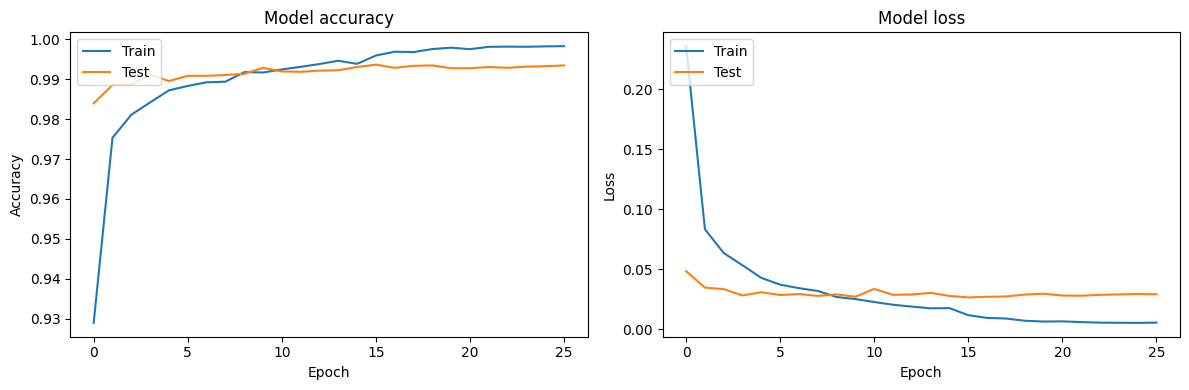

In [9]:
# Evaluate the model on the test data
score = model.evaluate(x_test_normalized, y_test_categorical, verbose=0)

print(f"\nTest loss: {score[0]:.4f}")
print(f"Test accuracy: {score[1]:.4f} ({(score[1]*100):.2f}%)")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


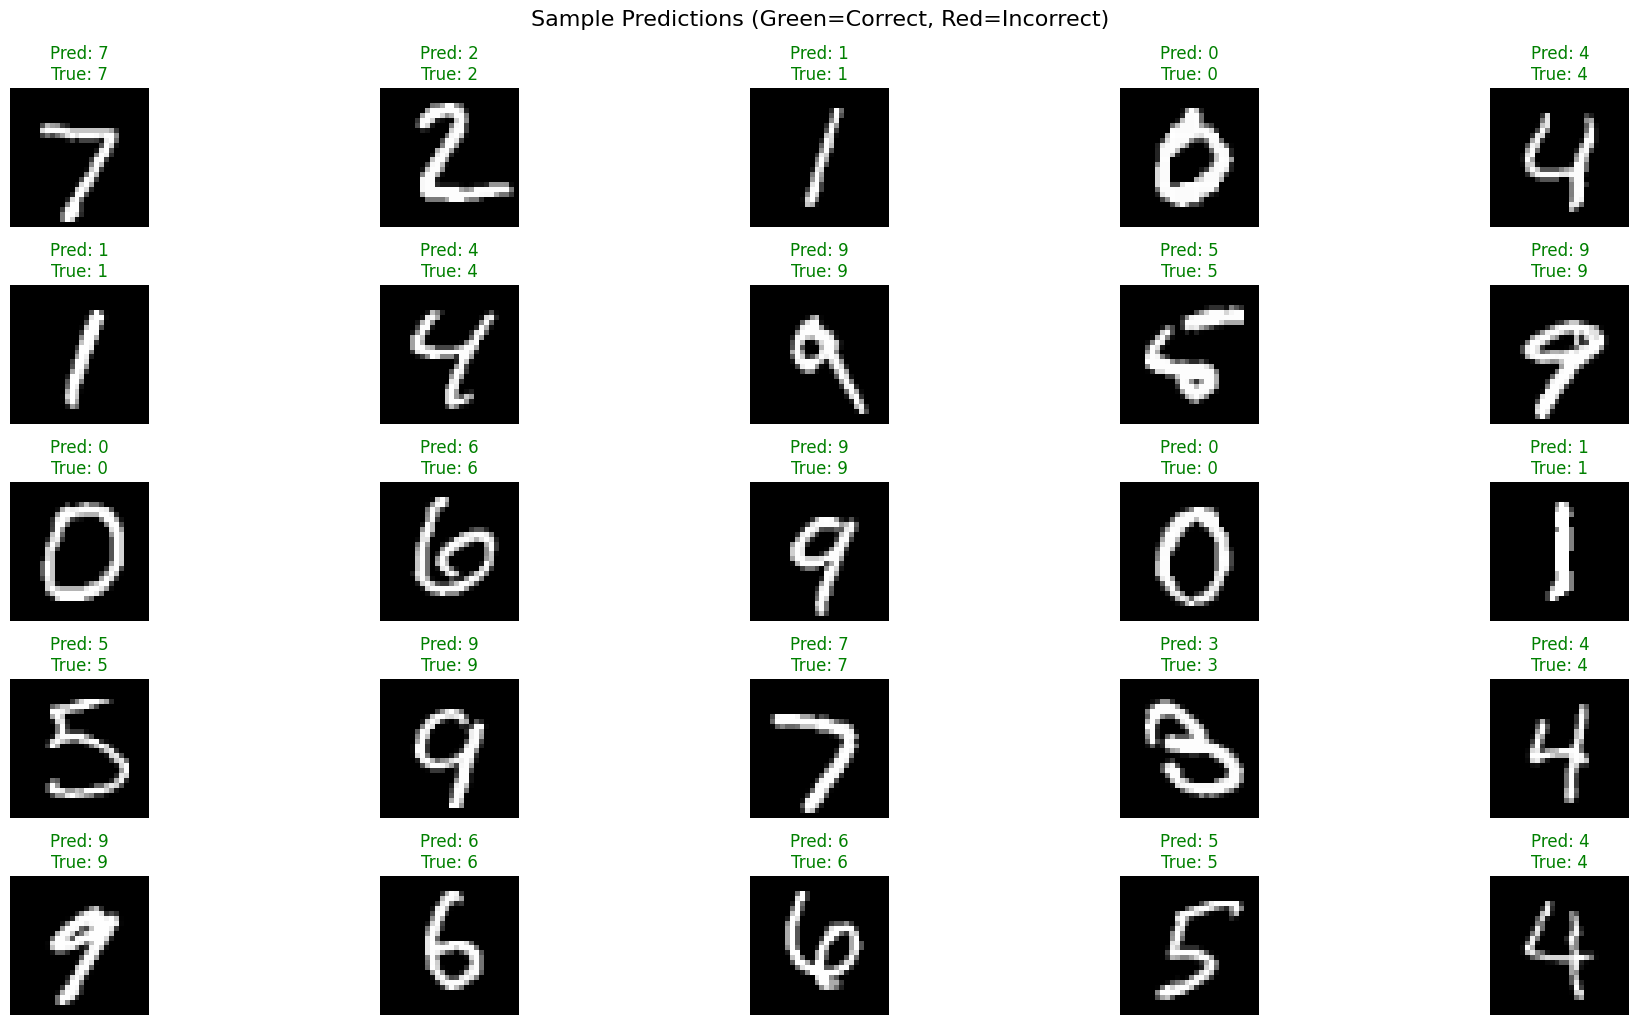


Found 64 misclassified images out of 10000.
Showing some misclassified examples:


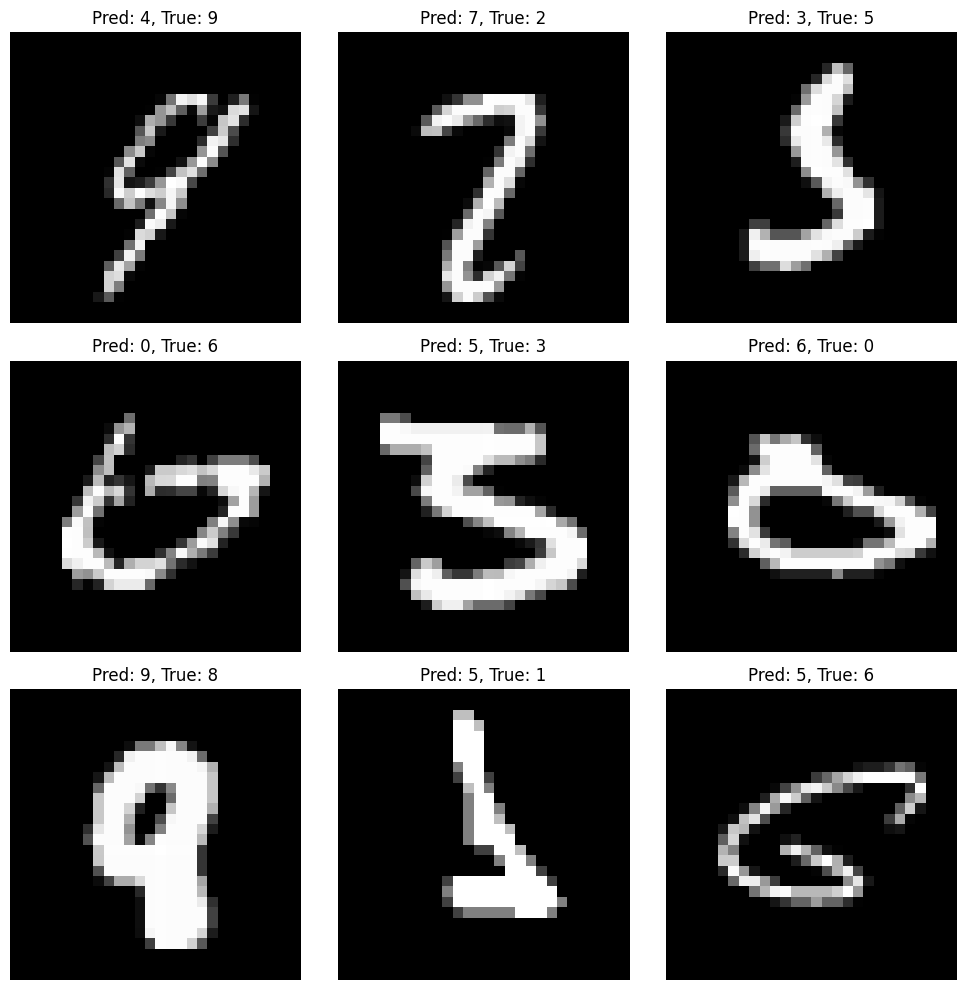

In [10]:
# Make predictions on the test set
predictions = model.predict(x_test_normalized)

# The output of model.predict is a probability distribution over the 10 classes
# For each image, we want to find the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels (original, not one-hot encoded)
true_classes = y_test # or np.argmax(y_test_categorical, axis=1)

# Display some test images with their predicted and true labels
num_rows = 5
num_cols = 5
num_images = num_rows * num_cols

plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows)) # Adjust figure size for better display
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(x_test[i], cmap='gray') # Use original x_test for plotting
    plt.title(f"Pred: {predicted_classes[i]}\nTrue: {true_classes[i]}",
              color='green' if predicted_classes[i] == true_classes[i] else 'red')
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Sample Predictions (Green=Correct, Red=Incorrect)", fontsize=16, y=1.02)
plt.show()

# Find and display some misclassified examples
misclassified_indices = np.where(predicted_classes != true_classes)[0]
print(f"\nFound {len(misclassified_indices)} misclassified images out of {len(x_test)}.")

if len(misclassified_indices) > 0:
    print("Showing some misclassified examples:")
    num_misclassified_to_show = min(len(misclassified_indices), 9) # Show up to 9
    plt.figure(figsize=(10, 10))
    for i, index in enumerate(misclassified_indices[:num_misclassified_to_show]):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_test[index], cmap='gray')
        plt.title(f"Pred: {predicted_classes[index]}, True: {true_classes[index]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images to show! (Highly unlikely for the first run, but good if true!)")

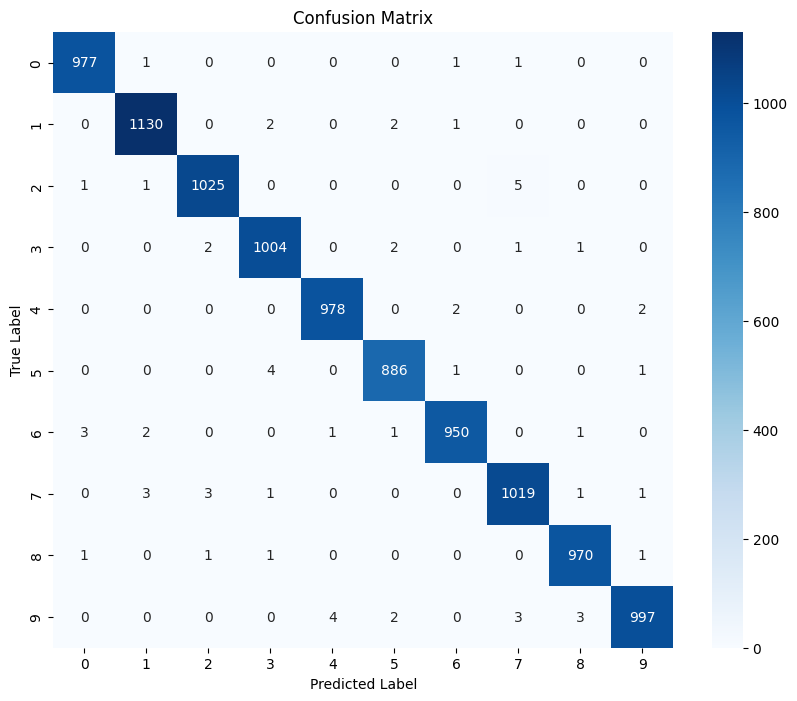


Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      1.00       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns # For a prettier confusion matrix

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=[str(i) for i in range(10)]))

--- Visualization Cell Start ---

Plotting CNN Learning Curves...


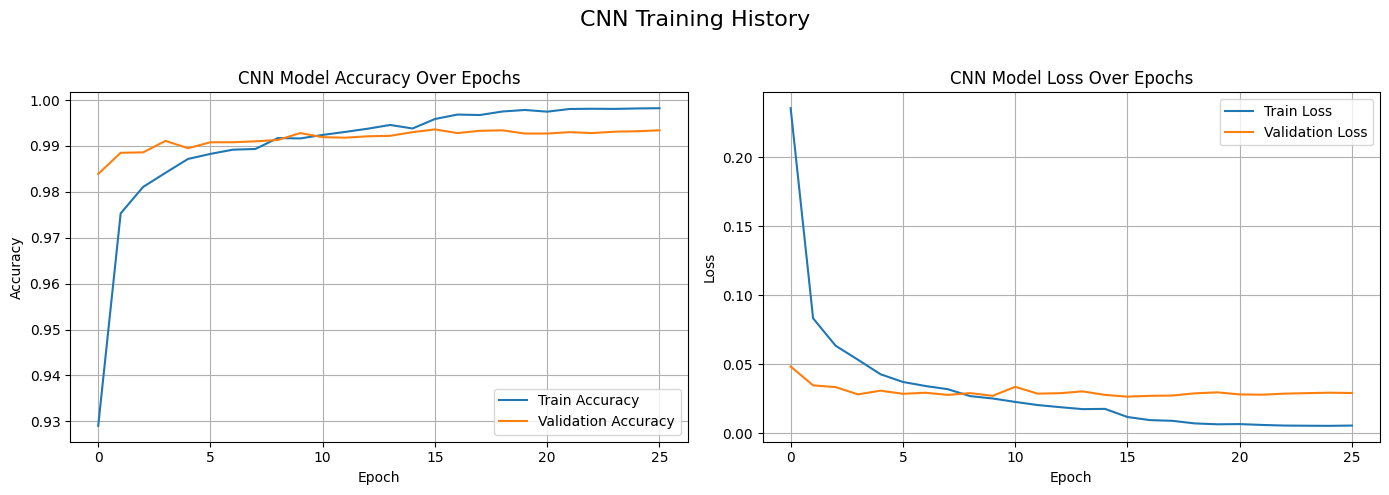


Plotting Model Accuracy Comparison...
CNN Test Accuracy: 99.36%


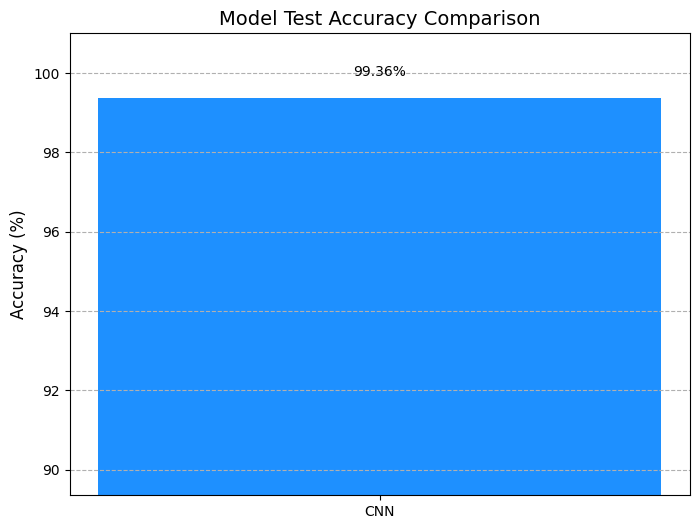


Plotting Sample CNN Predictions with Probabilities...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


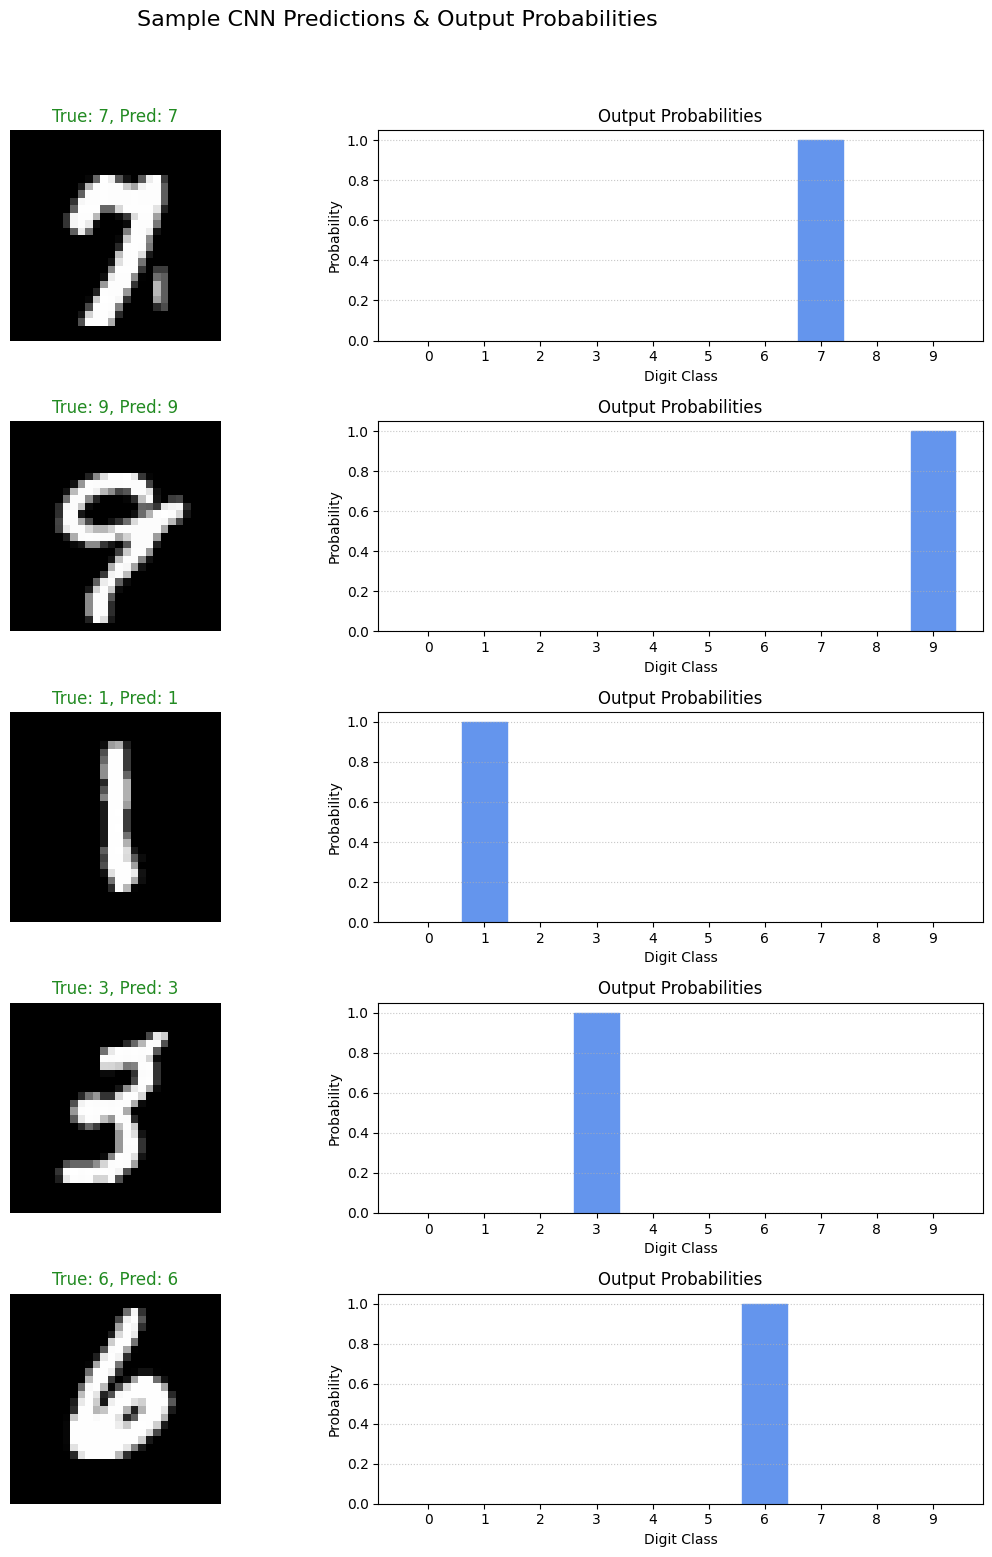


--- Visualization Cell End ---


In [12]:
# Combined Visualization Cell (Temporary for ease of use)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
# For ROC (optional, can uncomment if needed later)
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize
# from itertools import cycle

print("--- Visualization Cell Start ---")

# Ensure necessary variables are available from previous cells:
# history (Keras history object for CNN)
# model_to_evaluate_and_predict (your best trained CNN model)
# x_test, y_test (original test images and integer labels)
# x_test_normalized, y_test_categorical (preprocessed test data and one-hot labels)
# predicted_classes (CNN's predictions as integer labels for y_test)
# digit_class_names = [str(i) for i in range(10)]

# --- 1. Learning Curves for CNN (Assuming this might already be in another cell, but included for completeness) ---
if 'history' in locals() and history is not None:
    print("\nPlotting CNN Learning Curves...")
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('CNN Model Accuracy Over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('CNN Model Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.suptitle('CNN Training History', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("Warning: 'history' object not found. Skipping CNN learning curves.")

# --- 2. Confusion Matrix Function and Plots ---
def plot_confusion_matrix_custom(y_true, y_pred, class_names_list, model_title="Model"):
    """Plots a confusion matrix with better styling."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', # Changed cmap for variety
                xticklabels=class_names_list, yticklabels=class_names_list,
                linewidths=.5, linecolor='gray', cbar=True)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix - {model_title}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    # Also print classification report
    print(f"\nClassification Report - {model_title}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names_list, digits=4)) # Added digits for precision

# Plot for CNN
if 'predicted_classes' in locals() and 'y_test' in locals() and 'digit_class_names' in locals():
    print("\nPlotting CNN Confusion Matrix and Report...")
    plot_confusion_matrix_custom(y_test, predicted_classes, digit_class_names, model_title="CNN")
else:
    print("Warning: Variables for CNN confusion matrix not found (predicted_classes, y_test, digit_class_names).")

# Placeholder for MLP Confusion Matrix (Uncomment and adapt if you train an MLP)
# if 'mlp_predicted_classes' in locals() and 'y_test' in locals() and 'digit_class_names' in locals():
#     print("\nPlotting MLP Confusion Matrix and Report...")
#     plot_confusion_matrix_custom(y_test, mlp_predicted_classes, digit_class_names, model_title="MLP (Baseline)")
# else:
#     print("Info: Variables for MLP confusion matrix not found. Skipping.")


# --- 3. Visual Comparison of Model Accuracies ---
print("\nPlotting Model Accuracy Comparison...")
model_names_for_plot = []
accuracies_for_plot = []

# Get CNN accuracy
if 'model_to_evaluate_and_predict' in locals() and 'x_test_normalized' in locals() and 'y_test_categorical' in locals():
    try:
        score_cnn = model_to_evaluate_and_predict.evaluate(x_test_normalized, y_test_categorical, verbose=0)
        cnn_accuracy_percent = score_cnn[1] * 100
        model_names_for_plot.append('CNN')
        accuracies_for_plot.append(cnn_accuracy_percent)
        print(f"CNN Test Accuracy: {cnn_accuracy_percent:.2f}%")
    except Exception as e:
        print(f"Error evaluating CNN for accuracy plot: {e}")
else:
    print("Warning: Variables for CNN accuracy not found.")

# Placeholder for MLP accuracy (Uncomment and adapt if you train an MLP)
# if 'mlp_model' in locals() and 'x_test_flat_normalized' in locals() and 'y_test_categorical' in locals(): # Adapt input data var name
#     try:
#         score_mlp = mlp_model.evaluate(x_test_flat_normalized, y_test_categorical, verbose=0)
#         mlp_accuracy_percent = score_mlp[1] * 100
#         model_names_for_plot.append('MLP (Baseline)')
#         accuracies_for_plot.append(mlp_accuracy_percent)
#         print(f"MLP Test Accuracy: {mlp_accuracy_percent:.2f}%")
#     except Exception as e:
#         print(f"Error evaluating MLP for accuracy plot: {e}")
# else:
#     print("Info: Variables for MLP accuracy not found.")


if len(model_names_for_plot) > 0:
    plt.figure(figsize=(8, 6))
    bars = plt.bar(model_names_for_plot, accuracies_for_plot, color=['dodgerblue', 'salmon'][:len(model_names_for_plot)])
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Model Test Accuracy Comparison', fontsize=14)
    plt.ylim(max(0, min(accuracies_for_plot) - 10 if accuracies_for_plot else 0), 101) # Dynamic y-lim
    plt.grid(axis='y', linestyle='--')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10)
    plt.show()
else:
    print("No model accuracies to plot for comparison.")


# --- 4. Sample Predictions with Probabilities (CNN) ---
if 'model_to_evaluate_and_predict' in locals() and 'x_test' in locals() and 'y_test' in locals() and 'x_test_normalized' in locals():
    print("\nPlotting Sample CNN Predictions with Probabilities...")
    num_samples_to_show = 5
    try:
        sample_indices = np.random.choice(len(x_test), num_samples_to_show, replace=False)
        sample_images = x_test[sample_indices]
        sample_images_normalized = x_test_normalized[sample_indices]
        sample_true_labels = y_test[sample_indices]

        sample_predictions_proba = model_to_evaluate_and_predict.predict(sample_images_normalized)
        sample_predicted_labels = np.argmax(sample_predictions_proba, axis=1)

        fig, axes = plt.subplots(num_samples_to_show, 2, figsize=(12, 3 * num_samples_to_show + 1)) # Adjusted figsize
        fig.suptitle("Sample CNN Predictions & Output Probabilities", fontsize=16, y=1.0) # Adjusted y for suptitle

        for i in range(num_samples_to_show):
            # Display image
            axes[i, 0].imshow(sample_images[i], cmap='gray')
            title_color = 'forestgreen' if sample_predicted_labels[i] == sample_true_labels[i] else 'crimson'
            axes[i, 0].set_title(f"True: {sample_true_labels[i]}, Pred: {sample_predicted_labels[i]}", color=title_color, fontsize=12)
            axes[i, 0].axis('off')

            # Display probabilities
            bars_proba = axes[i, 1].bar(range(10), sample_predictions_proba[i], color='lightsteelblue')
            axes[i, 1].set_xticks(range(10))
            axes[i, 1].set_xticklabels(digit_class_names if 'digit_class_names' in locals() else range(10))
            axes[i, 1].set_ylim(0, 1.05)
            axes[i, 1].set_title("Output Probabilities", fontsize=12)
            axes[i, 1].set_ylabel("Probability", fontsize=10)
            axes[i, 1].set_xlabel("Digit Class", fontsize=10)
            axes[i, 1].grid(axis='y', linestyle=':', alpha=0.7)
            # Highlight the predicted class bar
            if sample_predicted_labels[i] < len(bars_proba): # Check index bounds
                 bars_proba[sample_predicted_labels[i]].set_color('cornflowerblue')


        plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to make space for suptitle
        plt.show()
    except Exception as e:
        print(f"Error during sample predictions plot: {e}")
else:
    print("Warning: Variables for sample predictions not found.")


# --- 5. ROC Curve (Optional - Uncomment and adapt if needed) ---
# print("\nPlotting ROC Curve Analysis (Multi-class for CNN)...")
# if 'model_to_evaluate_and_predict' in locals() and 'y_test' in locals() and 'x_test_normalized' in locals():
#     try:
#         y_test_binarized = label_binarize(y_test, classes=range(10))
#         n_classes = y_test_binarized.shape[1]
#         y_score_cnn = model_to_evaluate_and_predict.predict(x_test_normalized)

#         fpr, tpr, roc_auc = dict(), dict(), dict()
#         for i in range(n_classes):
#             fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_cnn[:, i])
#             roc_auc[i] = auc(fpr[i], tpr[i])

#         plt.figure(figsize=(12, 9)) # Adjusted size
#         colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
#                         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']) # Tableau10 colors
#         for i, color in zip(range(n_classes), colors):
#             plt.plot(fpr[i], tpr[i], color=color, lw=2,
#                      label=f'ROC class {i} (AUC = {roc_auc[i]:.3f})')

#         plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
#         plt.xlim([-0.05, 1.0])
#         plt.ylim([0.0, 1.05])
#         plt.xlabel('False Positive Rate', fontsize=12)
#         plt.ylabel('True Positive Rate', fontsize=12)
#         plt.title('Multi-class ROC Curves - CNN Model', fontsize=14)
#         plt.legend(loc="lower right", fontsize=10)
#         plt.grid(True)
#         plt.show()

#         # Micro-average ROC
#         fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score_cnn.ravel())
#         roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#         print(f"Micro-averaged ROC AUC score for CNN: {roc_auc['micro']:.4f}")

#         # Macro-average ROC
#         all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
#         mean_tpr = np.zeros_like(all_fpr)
#         for i in range(n_classes):
#             mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
#         mean_tpr /= n_classes
#         roc_auc["macro"] = auc(all_fpr, mean_tpr)
#         print(f"Macro-averaged ROC AUC score for CNN: {roc_auc['macro']:.4f}")

#     except Exception as e:
#         print(f"Error during ROC curve plot: {e}")
# else:
#     print("Warning: Variables for ROC curve not found. Skipping.")


print("\n--- Visualization Cell End ---")